# Problem statement, Data dictionary

Each sample is composed of data from 25 cells, covering an area of 625 m2. Each cell represents an area of 5 x 5 m2 and has nine features (as introduced in section 2). For a landslide sample, cell 13 is the location of landslide, and other cells are the neighboring areas. For a non-landslide sample, there is no recorded landslide occurrence within the sample area.

- CELLID_elevation	Continuous	
Digital elevation of the terrain surface in meter

- CELLID_slope	Continuous	
Angle of the slope inclination in degree

- CELLID_aspect	Continuous	
Exposition of the slope in degree
(direction of the slope?) -> dummied to 8 NSEW

- CELLID_placurv	Continuous	
Planform curvature, curvature perpendicular to the direction of the maximum slope

- CELLID_procurv	Continuous	
Profile curvature, curvature parallel to the slope, indicating the direction of maximum slope

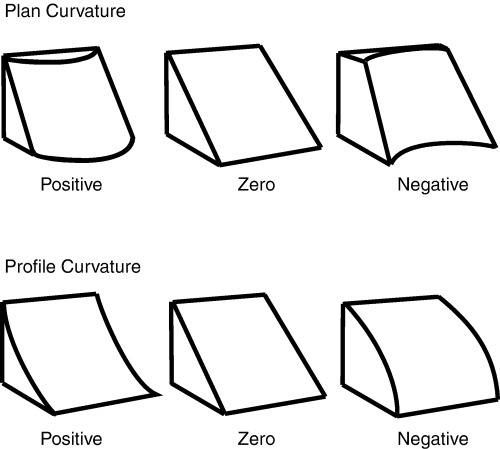


- CELLID_lsfactor	Continuous	
Length-slope factor that accounts for the effects of topography on erosion

- CELLID_twi	Continuous	
Topographic wetness index, an index to quantify the topographic control on hydrological process

- CELLID_geology	Categorical	Lithology of the surface material
1: Weathered Cretaceous granitic rocks
2: Weathered Jurassic granite rocks
3: Weathered Jurassic tuff and lava
4: Weathered Cretaceous tuff and lava
5: Quaternary deposits
6: Fill
7: Weathered Jurassic sandstone, siltstone and mudstone

- CELLID_sdoif	Continuous	
Step duration orographic intensification factor: an index to quantify the amplification of orography on rainfall


# 0. Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# all columns, limit 200 rows
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", 200)

# round up DISPLAY 4 decimal
pd.options.display.float_format = "{:,.4f}".format

import time

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.feature_selection import RFE



from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# !conda install -c conda-forge py-xgboost 
# !pip install xgboost
import xgboost as xgb

from sklearn.metrics import ( 
    f1_score, 
    accuracy_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    plot_confusion_matrix, 
    classification_report, 
    precision_recall_curve,
    make_scorer,
 
) 

C:\Users\nguye_5159g\anaconda3\envs\newbase010323\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1. Data preprocessing

In [2]:
df = pd.read_csv('landslide_engineered_features.csv')
df.head()

,Label,aspect_NSEW,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center
0,0,SE,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,++-,0.0214,+--,0.0668,19.2870,3.1545,3.4665,3,3,1.2817
1,1,S,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,+++,-0.0193,---,0.0055,16.6390,4.3839,4.6605,3,3,1.3596
2,0,W,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,+++,-0.0274,+++,0.0026,28.8700,4.1693,4.2278,2,2,1.3651
3,0,S,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,+++,-0.0229,+-+,0.0146,8.2114,4.2599,3.7378,2,2,1.1008
4,0,SE,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,---,0.0181,---,0.0205,15.8179,4.4302,4.5421,2,5,1.2842


In [3]:
# Dummy
to_dummies = ['aspect_NSEW']
aspect_NSEW_dummies = pd.get_dummies(df[to_dummies], drop_first=True)
aspect_NSEW_dummies.columns = [x.replace('_NSEW','') for x in aspect_NSEW_dummies.columns]
df = pd.concat([df, aspect_NSEW_dummies], axis=1)

df.drop(columns='aspect_NSEW', inplace=True)

In [5]:
# convert to woe
from custom_functions import WOE

temp = pd.read_csv('df\Train.csv')
placurv_cols = temp.columns[1+25*3:26+25*3].tolist()
procurv_cols = temp.columns[1+25*4:26+25*4].tolist()

df = pd.concat([df, temp[placurv_cols]], axis=1)
df.placurv_signs_8 = df.placurv_signs_8.map(WOE.convert_woe_cat('placurv_signs_8', df)['WOE'])

df = pd.concat([df, temp[procurv_cols]], axis=1)
df.procurv_signs_8 = df.procurv_signs_8.map(WOE.convert_woe_cat('procurv_signs_8', df)['WOE'])

df.drop(columns=placurv_cols+procurv_cols, inplace=True)

Information value: 0.13
Information value: 0.11


In [6]:
df.head()

,Label,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center,aspect_N,aspect_NE,aspect_NW,aspect_S,aspect_SE,aspect_SW,aspect_W
0,0,119,20,44.5637,34.9797,37.8750,35.4213,0.0136,0.1635,0.0214,0.3706,0.0668,19.2870,3.1545,3.4665,3,3,1.2817,0,0,0,0,1,0,0
1,1,156,12,32.3115,41.6662,29.7449,91.5230,-0.0026,-0.4845,-0.0193,0.1837,0.0055,16.6390,4.3839,4.6605,3,3,1.3596,0,0,0,1,0,0,0
2,0,164,22,45.0000,77.7087,62.4027,106.3306,0.0048,-0.4845,-0.0274,-0.4567,0.0026,28.8700,4.1693,4.2278,2,2,1.3651,0,0,0,0,0,0,1
3,0,77,8,16.6992,86.5494,78.6901,45.0000,0.0089,-0.4845,-0.0229,-0.3943,0.0146,8.2114,4.2599,3.7378,2,2,1.1008,0,0,0,1,0,0,0
4,0,109,15,29.4962,32.6895,18.4350,72.4050,-0.0006,0.1881,0.0181,0.1837,0.0205,15.8179,4.4302,4.5421,2,5,1.2842,0,0,0,0,1,0,0


## Train/test, scale

In [7]:
X = df.drop(columns='Label')
Y = df.Label

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.1, random_state=14)

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index = X_train.index, columns = X_train.columns)

X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), index = X_test.index, columns = X_test.columns)

# 2. Logistic Regression

In [8]:
# add constant for statmodel
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

## Custom functions

In [9]:
from custom_functions import classification_functions as clf

## Building model 1

### Feature selection

RFE can be used to select the best n features, but we have to decide how many n features we need. The code below will calculate with each n features, what is the highest VIF value among said n features to provide us a starting point.

In [10]:
def max_vif_n_features(features):
    '''
    features: list like, without 'const'
    '''
    max_vif_values = []
    model = LogisticRegression()
    X_data = X_train_scaled[['const'] + features]
    starting = 5

    # loop to calculate max VIF among n features
    for n_features in range(starting, X_data.iloc[:,1:].shape[1] + 1):
        rfe = RFE(model, n_features_to_select = n_features)
        rfe.fit(X_data.iloc[:,1:], y_train) 
        # top features selected
        top_n_features = rfe.get_feature_names_out(X_data.iloc[:,1:].columns).tolist()
        # calculate the highest vif values among the selected features
        vif_for_n_features = [vif(X_data[['const'] + top_n_features].values, i) for i in range(n_features+1)]
        max_vif_value = pd.Series(vif_for_n_features[1:]).max()
        max_vif_values = max_vif_values + [max_vif_value]
        if max_vif_value > 20:
            break

    df_result = pd.DataFrame({
        'n_features': range(starting, len(max_vif_values) + starting),
        'max_vif_value': max_vif_values
    })
    return df_result.sort_values('n_features', ascending=False)

In [11]:
model_lg1_features = X_train_scaled.columns[1:].tolist()

max_vif_n_features(model_lg1_features)

,n_features,max_vif_value
19,24,6.6530
18,23,6.6520
17,22,6.6511
16,21,6.6236
15,20,6.5869
14,19,6.5672
13,18,5.9012
12,17,5.8875
11,16,5.1866
10,15,5.1827


In [12]:
# Function to select n features using RFE
def rfe_top_features(features, n_features):
    X_data = X_train_scaled[['const'] + features]
    y_data = y_train
    
    model = LogisticRegression(max_iter=200)
    rfe = RFE(model, n_features_to_select=n_features)
    rfe.fit(X_data,y_data) 
    result = pd.DataFrame({'ranking': rfe.ranking_, 'features': X_data.columns}).sort_values('ranking')
    
    print(f'Top {n_features} features:')
    return rfe.get_feature_names_out().tolist()

In [13]:
model_lg1_top_features = rfe_top_features(model_lg1_features, 12)
model_lg1_top_features

Top 12 features:


['elevation_center',
 'elevation_minmax_difference',
 'slope_center',
 'placurv_center_below_diff',
 'placurv_signs_8',
 'placurv_top_vs_2bottom',
 'procurv_top_vs_2bottom',
 'lsfactor_sum_center_1below',
 'twi_center',
 'twi_25mean',
 'geology_center',
 'sdoif_center']

### Checking multicollinearity

In [14]:
def checking_vif(top_features):
    data = X_train_scaled[['const'] + top_features]
    result = pd.DataFrame()
    result['feature'] = data.columns

    # Calculating VIF for each feature
    result['VIF'] = [
        vif(data.values, i) for i in range(len(data.columns))
    ]
    result['VIF'] = result['VIF'].apply(lambda x: round(x,2))
    return result.sort_values('VIF', ascending=False)

In [15]:
checking_vif(model_lg1_top_features)

,feature,VIF
0,const,140.5900
3,slope_center,5.1500
6,placurv_top_vs_2bottom,3.9100
2,elevation_minmax_difference,3.8700
8,lsfactor_sum_center_1below,3.6500
10,twi_25mean,2.9700
9,twi_center,2.8700
4,placurv_center_below_diff,2.5300
5,placurv_signs_8,1.8500
7,procurv_top_vs_2bottom,1.4400


In [16]:
model_lg1_top_features.remove('slope_center')
checking_vif(model_lg1_top_features)

,feature,VIF
0,const,139.3700
5,placurv_top_vs_2bottom,3.9100
2,elevation_minmax_difference,3.0100
9,twi_25mean,2.9700
7,lsfactor_sum_center_1below,2.6600
3,placurv_center_below_diff,2.5200
8,twi_center,2.3600
4,placurv_signs_8,1.8500
6,procurv_top_vs_2bottom,1.3800
1,elevation_center,1.3300


<AxesSubplot: >

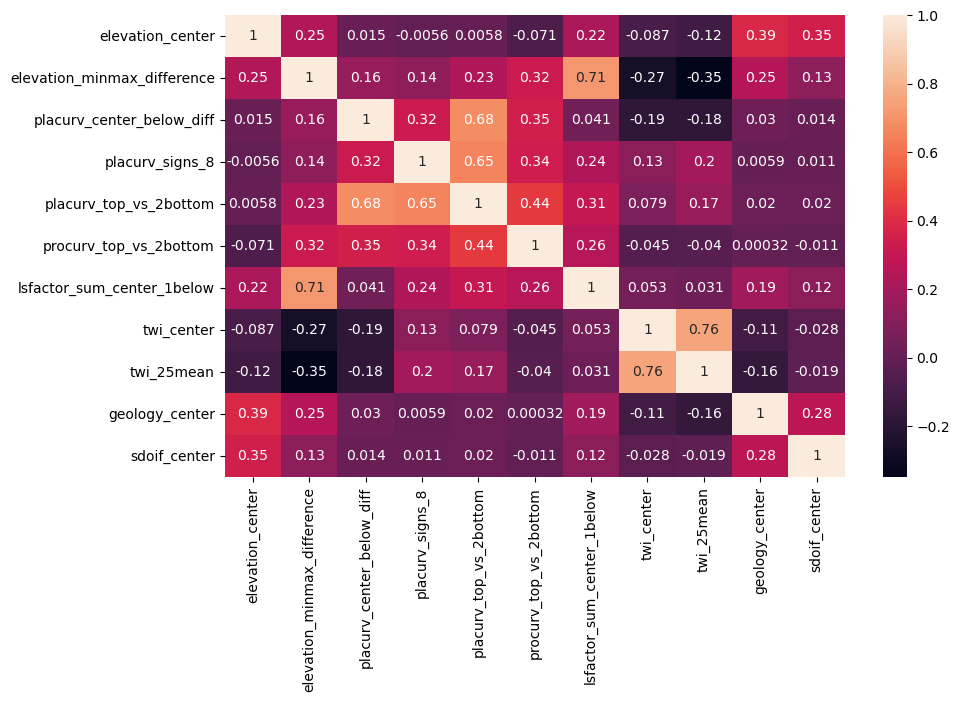

In [17]:
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

<AxesSubplot: >

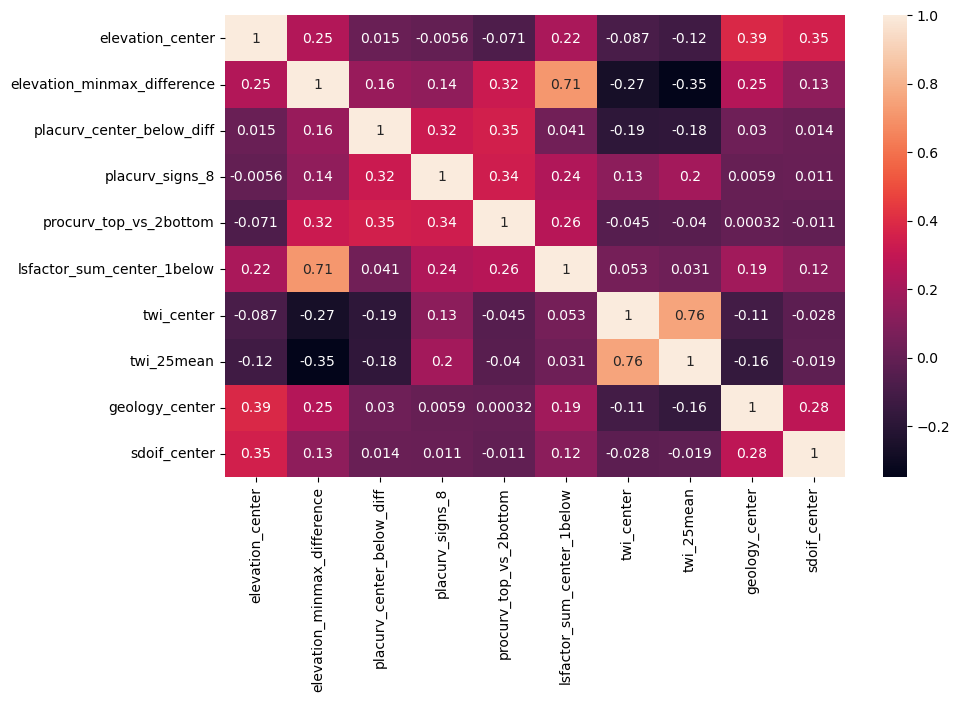

In [18]:
model_lg1_top_features.remove('placurv_top_vs_2bottom')
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

<AxesSubplot: >

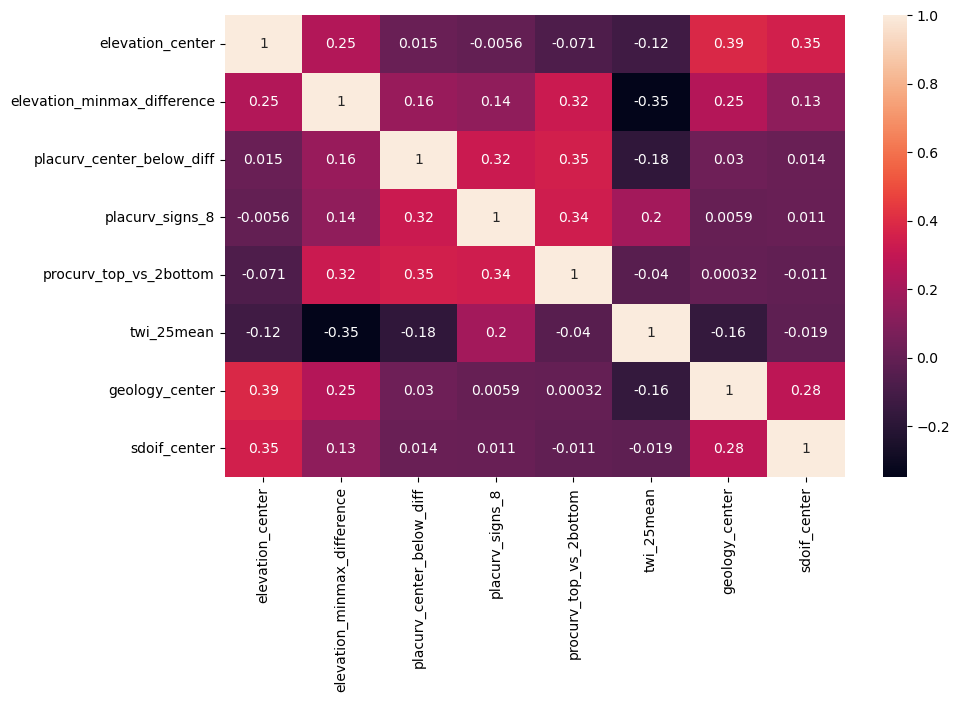

In [19]:
model_lg1_top_features.remove('twi_center')
model_lg1_top_features.remove('lsfactor_sum_center_1below')
plt.figure(figsize=(10,6))
sns.heatmap(X_train_scaled[model_lg1_top_features].corr(), annot=True)

### Fit model

In [20]:
# function for fitting the data and display confusion matrix in one line

def build_lg(features, threshold=0.5, cf=True, score=True):
    '''
    features: list like, excluding const
    '''
    logres = sm.GLM(y_train, X_train_scaled[['const'] + features], family = sm.families.Binomial())
    model = logres.fit()
    print(model.summary())
    
    yhat_train = model.predict(X_train_scaled[['const'] + features])
    yhat_train = yhat_train.apply(lambda x: 1 if x>threshold else 0)
    yhat_test = model.predict(X_test_scaled[['const'] + features])
    yhat_test = yhat_test.apply(lambda x: 1 if x>threshold else 0)
    
    if cf:
        clf.cf_train_test(y_train, yhat_train, y_test, yhat_test)
    if score:
        print('Train')
        print(classification_report(y_train, yhat_train))
        print('Test')
        print(classification_report(y_test, yhat_test))
    return model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9768
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.1
Date:                Sun, 30 Apr 2023   Deviance:                       8592.2
Time:                        17:54:58   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2179
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

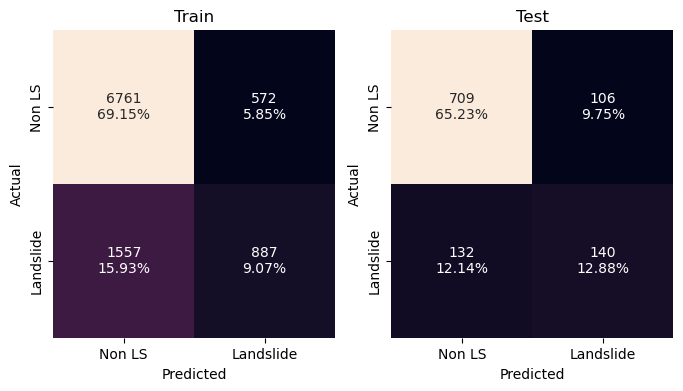

Train
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7333
           1       0.61      0.36      0.45      2444

    accuracy                           0.78      9777
   macro avg       0.71      0.64      0.66      9777
weighted avg       0.76      0.78      0.76      9777

Test
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       815
           1       0.57      0.51      0.54       272

    accuracy                           0.78      1087
   macro avg       0.71      0.69      0.70      1087
weighted avg       0.77      0.78      0.78      1087



In [21]:
model_lg1 = build_lg(model_lg1_top_features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.7
Date:                Sun, 30 Apr 2023   Deviance:                       8593.4
Time:                        17:54:58   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2178
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

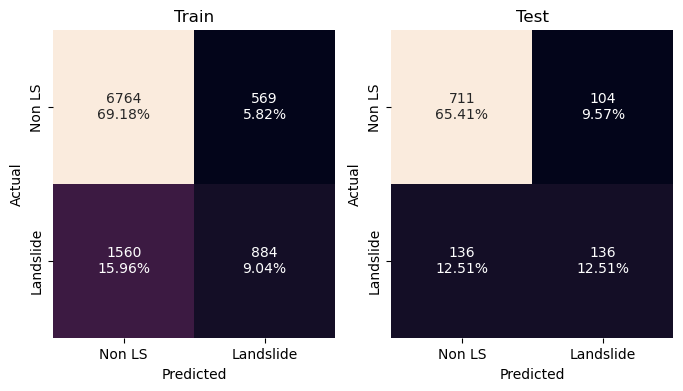

Train
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      7333
           1       0.61      0.36      0.45      2444

    accuracy                           0.78      9777
   macro avg       0.71      0.64      0.66      9777
weighted avg       0.76      0.78      0.76      9777

Test
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       815
           1       0.57      0.50      0.53       272

    accuracy                           0.78      1087
   macro avg       0.70      0.69      0.69      1087
weighted avg       0.77      0.78      0.77      1087



In [22]:
model_lg1_top_features.remove('procurv_top_vs_2bottom')
model_lg1 = build_lg(model_lg1_top_features)

In [23]:
# function to plot precision/recall curve
def pre_rec_curve(model, features, threshold=0.5):
    X_data = X_train_scaled[['const']+features]

    y_scores=model.predict(X_data)

    precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
    thresholds = np.insert(thresholds, 0, 0)
    F1_score = 2*precisions*recalls/(precisions+recalls)


    # Plot values of precisions, recalls, and thresholds
    plt.figure(figsize=(10,7))
    plt.plot(thresholds, precisions, 'b--', label='precision')
    plt.plot(thresholds, recalls, 'g--', label = 'recall')
    plt.plot(thresholds, F1_score, 'r--', label = 'f1 score')

    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0.4,1])
    plt.axvline(threshold)
    plt.show()

C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_18448\752658623.py:9: RuntimeWarning: invalid value encountered in true_divide
  F1_score = 2*precisions*recalls/(precisions+recalls)


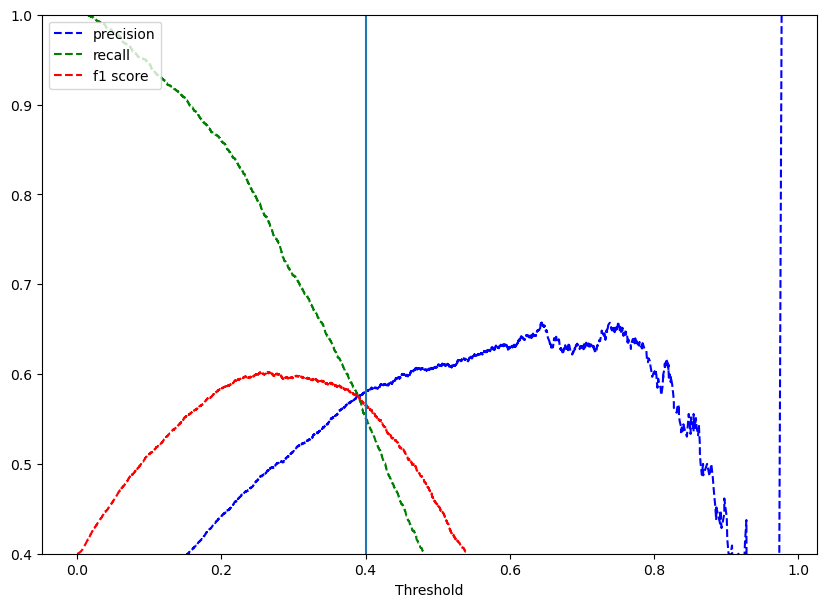

In [24]:
pre_rec_curve(model_lg1, model_lg1_top_features, threshold=0.4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4296.7
Date:                Sun, 30 Apr 2023   Deviance:                       8593.4
Time:                        17:54:58   Pearson chi2:                 9.58e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2178
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

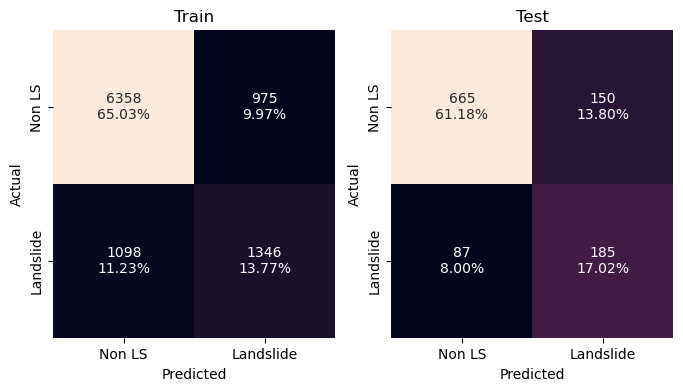

Train
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7333
           1       0.58      0.55      0.56      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.71      0.71      9777
weighted avg       0.78      0.79      0.79      9777

Test
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       815
           1       0.55      0.68      0.61       272

    accuracy                           0.78      1087
   macro avg       0.72      0.75      0.73      1087
weighted avg       0.80      0.78      0.79      1087



In [25]:
model_lg1 = build_lg(model_lg1_top_features, threshold=0.4)

## Building model 2

### Feature selection

In [26]:
X_train_scaled

,const,elevation_center,elevation_minmax_difference,slope_center,slope_difference_pct,aspect_span,aspect_sum_span_9cells,placurv_center_below_diff,placurv_signs_8,placurv_top_vs_2bottom,procurv_signs_8,procurv_top_vs_2bottom,lsfactor_sum_center_1below,twi_center,twi_25mean,geology_center,geology_9mode,sdoif_center,aspect_N,aspect_NE,aspect_NW,aspect_S,aspect_SE,aspect_SW,aspect_W
6613,1.0000,0.0576,0.1224,0.2543,0.1776,0.8959,0.3432,0.4438,0.7752,0.3266,0.8122,0.4797,0.0001,0.3953,0.8625,1.0000,0.3333,0.7320,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4788,1.0000,0.1375,0.3061,0.3878,0.0856,0.2132,0.0373,0.4965,0.7938,0.4533,1.0000,0.5328,0.2456,0.1474,0.1613,1.0000,1.0000,0.7986,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
4863,1.0000,0.0898,0.2449,0.3878,0.0590,0.1244,0.0359,0.4795,0.2846,0.3404,0.7997,0.5101,0.1638,0.1317,0.1624,1.0000,0.3333,0.6638,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
5864,1.0000,0.0776,0.1020,0.1737,0.1224,0.2573,0.0635,0.4607,0.2846,0.2901,0.2316,0.4394,0.0857,0.2106,0.1575,0.5000,0.6667,0.4994,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5693,1.0000,0.5288,0.1837,0.2906,0.0462,0.0579,0.0335,0.4651,1.0000,0.3425,0.2316,0.4892,0.1797,0.1642,0.2059,1.0000,0.3333,0.8589,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,1.0000,0.2151,0.2449,0.2543,0.2131,0.8230,0.2766,0.3830,0.7938,0.3135,0.8122,0.4985,0.2701,0.3469,0.3584,0.0000,0.0000,0.6597,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3755,1.0000,0.4213,0.2449,0.4671,0.0696,0.3291,0.0459,0.5830,1.0000,0.4352,1.0000,0.5883,0.1748,0.0526,0.0960,1.0000,0.3333,0.9651,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
9026,1.0000,0.1286,0.2857,0.4671,0.0879,0.1962,0.0406,0.5147,0.7938,0.4058,0.8122,0.6482,0.3104,0.1876,0.1909,1.0000,0.3333,0.7377,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
299,1.0000,0.5055,0.4082,0.6546,0.0230,0.1197,0.0307,0.4138,0.2846,0.1855,0.8122,0.5093,0.3323,0.1114,0.1672,1.0000,0.3333,0.7846,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000


In [27]:
for feature in X_train_scaled.columns[1:]:
    print(feature)
    WOE.convert_woe(feature, df)
    print('------------------------')

elevation_center
Information value: 0.28
------------------------
elevation_minmax_difference
Information value: 0.92
------------------------
slope_center
Information value: 1.06
------------------------
slope_difference_pct
Information value: 0.18
------------------------
aspect_span
Information value: 0.09
------------------------
aspect_sum_span_9cells
Information value: 0.05
------------------------
placurv_center_below_diff
Information value: 0.06
------------------------
placurv_signs_8
Information value: 0.13
------------------------
placurv_top_vs_2bottom
Information value: 0.16
------------------------
procurv_signs_8
Information value: 0.11
------------------------
procurv_top_vs_2bottom
Information value: 0.11
------------------------
lsfactor_sum_center_1below
Information value: 0.69
------------------------
twi_center
Information value: 0.24
------------------------
twi_25mean
Information value: 0.40
------------------------
geology_center
Information value: 0.58
--------

Handpick the variables with highest IV

In [28]:
model_lg2_features = [
    'elevation_minmax_difference', 
    'slope_center', 
    'aspect_span',
    'placurv_top_vs_2bottom', 
    'procurv_top_vs_2bottom',
    'lsfactor_sum_center_1below',
    'twi_25mean',
    'geology_center', 
    'sdoif_center'
]

### Checking multicollinearity

In [29]:
checking_vif(model_lg2_features)

,feature,VIF
0,const,81.9200
2,slope_center,4.2500
1,elevation_minmax_difference,3.8400
6,lsfactor_sum_center_1below,3.3500
7,twi_25mean,1.6200
4,placurv_top_vs_2bottom,1.4400
5,procurv_top_vs_2bottom,1.3900
3,aspect_span,1.2300
8,geology_center,1.1700
9,sdoif_center,1.1000


<AxesSubplot: >

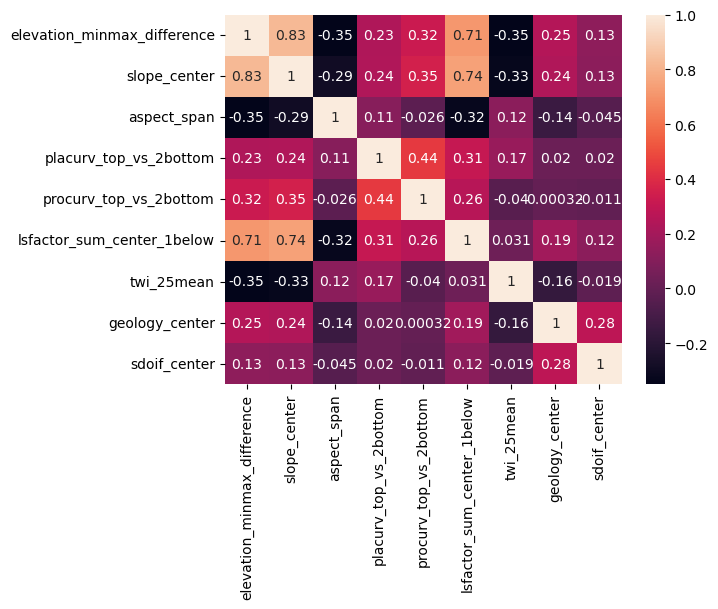

In [30]:
sns.heatmap(X_train_scaled[model_lg2_features].corr(), annot=True)

<AxesSubplot: >

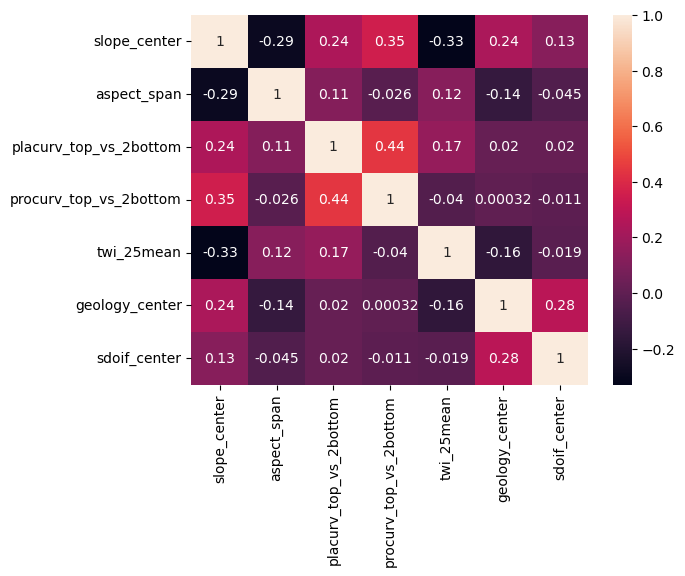

In [31]:
model_lg2_features.remove('elevation_minmax_difference')
model_lg2_features.remove('lsfactor_sum_center_1below')
sns.heatmap(X_train_scaled[model_lg2_features].corr(), annot=True)

### Build model

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9769
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 30 Apr 2023   Deviance:                       8460.0
Time:                        17:55:52   Pearson chi2:                 9.47e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

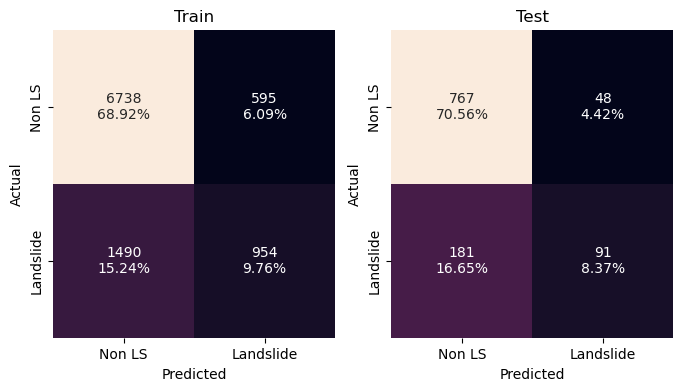

Train
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      7333
           1       0.62      0.39      0.48      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.65      0.67      9777
weighted avg       0.77      0.79      0.77      9777

Test
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       815
           1       0.65      0.33      0.44       272

    accuracy                           0.79      1087
   macro avg       0.73      0.64      0.66      1087
weighted avg       0.77      0.79      0.76      1087



In [32]:
model_lg2 = build_lg(model_lg2_features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9770
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 30 Apr 2023   Deviance:                       8460.1
Time:                        17:55:55   Pearson chi2:                 9.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

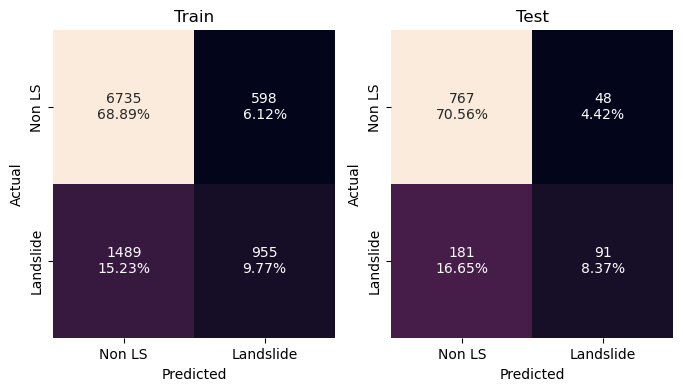

Train
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      7333
           1       0.61      0.39      0.48      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.65      0.67      9777
weighted avg       0.77      0.79      0.77      9777

Test
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       815
           1       0.65      0.33      0.44       272

    accuracy                           0.79      1087
   macro avg       0.73      0.64      0.66      1087
weighted avg       0.77      0.79      0.76      1087



In [33]:
model_lg2_features.remove("aspect_span")
model_lg2 = build_lg(model_lg2_features)

C:\Users\nguye_5159g\AppData\Local\Temp\ipykernel_18448\752658623.py:9: RuntimeWarning: invalid value encountered in true_divide
  F1_score = 2*precisions*recalls/(precisions+recalls)


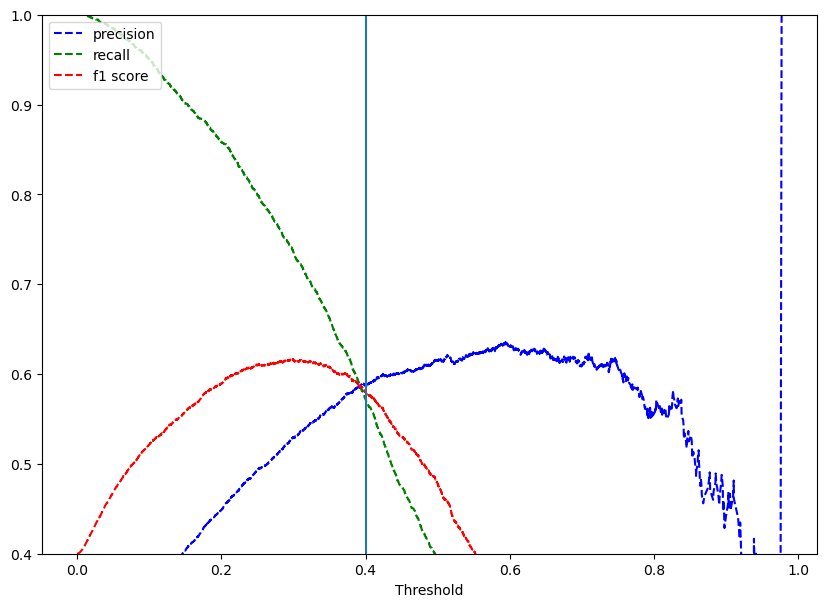

In [34]:
pre_rec_curve(model_lg2, model_lg2_features, threshold=0.4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Label   No. Observations:                 9777
Model:                            GLM   Df Residuals:                     9770
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4230.0
Date:                Sun, 30 Apr 2023   Deviance:                       8460.1
Time:                        17:56:00   Pearson chi2:                 9.48e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2284
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -6

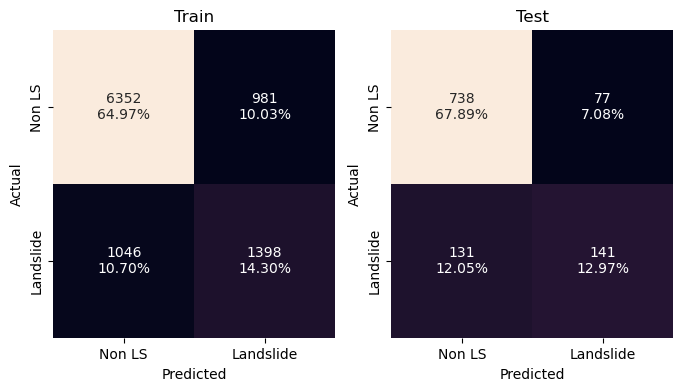

Train
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7333
           1       0.59      0.57      0.58      2444

    accuracy                           0.79      9777
   macro avg       0.72      0.72      0.72      9777
weighted avg       0.79      0.79      0.79      9777

Test
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       815
           1       0.65      0.52      0.58       272

    accuracy                           0.81      1087
   macro avg       0.75      0.71      0.73      1087
weighted avg       0.80      0.81      0.80      1087



In [35]:
model_lg2 = build_lg(model_lg2_features, threshold=0.4)

## Comparing AUC

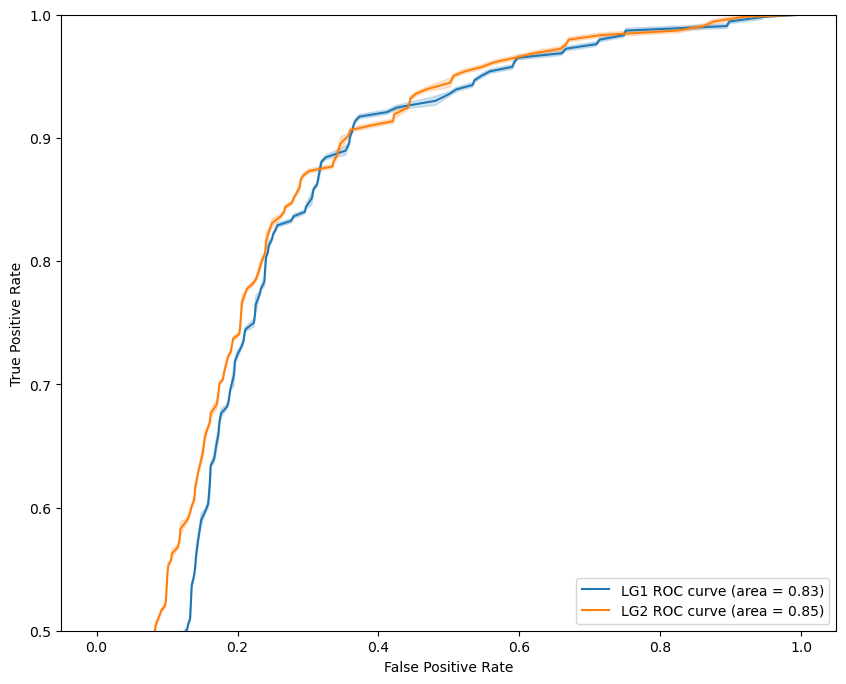

In [36]:
plt.figure(figsize=(10,8))
for model, model_name, feature in [
    (model_lg1, 'LG1', model_lg1_top_features),
    (model_lg2, 'LG2', model_lg2_features)
]:
    yhat_proba = model.predict(X_test_scaled[['const']+feature])
    fpr, tpr, _ = metrics.roc_curve(y_test,  yhat_proba)
    auc_score = metrics.roc_auc_score( y_test, yhat_proba )
    sns.lineplot(x=fpr,y=tpr, label=model_name + ' ROC curve (area = %0.2f)' % auc_score)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.ylim(0.5,1)
plt.show()    